# Look at debugging outputs

In [1]:
import os
import json
import numpy as np
from collections import defaultdict
import pprint
from nltk.translate.bleu_score import sentence_bleu

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image
import matplotlib.image as mpimg

In [2]:
class args:
    pass

args.dout = 'exp_all/model:seq2seq_nl_baseline,name:full_5_epoch_50_high_level_instrs'

In [3]:
!ls -l exp_all/model:seq2seq_nl_baseline,name:full_5_epoch_50_high_level_instrs

total 0
-rwxrwxrwx 1 root root       697 Apr 17 03:16 best_seen.json
-rwxrwxrwx 1 root root 153982185 Apr 17 03:16 best_seen.pth
-rwxrwxrwx 1 root root       697 Apr 17 03:16 best_train_sanity.json
-rwxrwxrwx 1 root root 153982185 Apr 17 03:16 best_train_sanity.pth
-rwxrwxrwx 1 root root       697 Apr 17 03:16 best_unseen.json
-rwxrwxrwx 1 root root 153982185 Apr 17 03:16 best_unseen.pth
-rwxrwxrwx 1 root root       916 Apr 17 03:16 config.json
-rwxrwxrwx 1 root root     39718 Apr 17 06:46 events.out.tfevents.1587102769.20ef41f5083f
-rwxrwxrwx 1 root root     39754 Apr 17 06:46 events.out.tfevents.1587103167.20ef41f5083f
-rwxrwxrwx 1 root root     39754 Apr 17 06:46 events.out.tfevents.1587103516.20ef41f5083f
-rwxrwxrwx 1 root root     39754 Apr 17 06:46 events.out.tfevents.1587103640.20ef41f5083f
-rwxrwxrwx 1 root root     39754 Apr 17 06:46 events.out.tfevents.1587103688.20ef41f5083f
-rwxrwxrwx 1 root root     39754 Apr 17 06:46 events.out.tfevents.1587103738.20ef41f5083f
-rwxrwxrwx 

In [4]:
valid_seen_epoch_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
valid_unseen_epoch_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]

# Examine Outputs across Epochs

- across epochs
- random selection
- rank by CE, BLEU

### SECTION 1: Select a random set of tasks to look at

#### Real Data

In [5]:
np.random.seed(42)

path = os.path.join(args.dout, 'valid_seen.debug_epoch_0.preds.json')
with open(path, 'r') as f:
    debug_valid_seen = json.load(f)
chosen_valid_seen_task_ids = np.random.choice(list(debug_valid_seen.keys()), size=10, replace=False)

path = os.path.join(args.dout, 'valid_unseen.debug_epoch_0.preds.json')
with open(path, 'r') as f:
    debug_valid_unseen = json.load(f)
chosen_valid_unseen_task_ids = np.random.choice(list(debug_valid_unseen.keys()), size=10, replace=False)

def find_num_high_level_goals(chosen_task_ids, debug_dat):
    '''number of high level goals (complexity) of these chosen tasks'''
    for t in chosen_task_ids:
        print (t, '\t\t\t', len(debug_dat[t]['action_high']))
    
print("\nRandomly Selected for Valid Seen: (task, number of planner subgoals)")
find_num_high_level_goals(chosen_valid_seen_task_ids, debug_valid_seen)
print("\nRandomly Selected for Valid Unseen: (task, number of planner subgoals)")
find_num_high_level_goals(chosen_valid_unseen_task_ids, debug_valid_unseen)


Randomly Selected for Valid Seen: (task, number of planner subgoals)
trial_T20190909_150916_682139_0 			 5
trial_T20190908_192636_561572_0 			 8
trial_T20190907_013001_399963_0 			 12
trial_T20190907_074712_870488_0 			 8
trial_T20190908_102840_789300_0 			 9
trial_T20190909_031040_889814_0 			 5
trial_T20190908_140701_251653_0 			 7
trial_T20190909_055649_717880_0 			 9
trial_T20190907_151802_277016_0 			 13
trial_T20190909_032318_169393_0 			 5

Randomly Selected for Valid Unseen: (task, number of planner subgoals)
trial_T20190909_123918_983775_0 			 13
trial_T20190909_123732_489327_0 			 11
trial_T20190906_191445_723170_0 			 5
trial_T20190907_020329_050110_0 			 7
trial_T20190907_170955_824797_0 			 5
trial_T20190909_210238_431966_0 			 5
trial_T20190906_224843_443882_0 			 13
trial_T20190906_214631_761426_0 			 5
trial_T20190907_074524_006355_0 			 5
trial_T20190908_114656_768805_0 			 7


In [6]:
chosen_valid_seen_task_ids = [
'trial_T20190909_150916_682139_0', 
'trial_T20190908_192636_561572_0', 
'trial_T20190907_013001_399963_0', 
'trial_T20190907_074712_870488_0', 
'trial_T20190908_102840_789300_0', 
'trial_T20190909_031040_889814_0', 
'trial_T20190908_140701_251653_0', 
'trial_T20190909_055649_717880_0', 
'trial_T20190907_151802_277016_0', 
'trial_T20190909_032318_169393_0'
]

chosen_valid_unseen_task_ids = [
'trial_T20190909_123918_983775_0',
'trial_T20190909_123732_489327_0',
'trial_T20190906_191445_723170_0',
'trial_T20190907_020329_050110_0',
'trial_T20190907_170955_824797_0',
'trial_T20190909_210238_431966_0',
'trial_T20190906_224843_443882_0',
'trial_T20190906_214631_761426_0',
'trial_T20190907_074524_006355_0',
'trial_T20190908_114656_768805_0'
]

In [7]:
urls = {
    'trial_T20190909_150916_682139_0' : 'https://youtu.be/FHGCyxlwp8E',
    'trial_T20190908_192636_561572_0': 'https://youtu.be/KYG5NEfVbjM', 
    'trial_T20190907_013001_399963_0' : 'https://youtu.be/ezmpJhbhCpI',
    'trial_T20190907_074712_870488_0':  'https://youtu.be/civKnURZaR0',
    'trial_T20190908_102840_789300_0': 'https://youtu.be/Dg9dzxXmxB4',
    'trial_T20190909_031040_889814_0': 'https://youtu.be/TpFjTu0nRoA',
    'trial_T20190908_140701_251653_0': 'https://youtu.be/LQpzGDzww1A',
    'trial_T20190909_055649_717880_0': 'https://youtu.be/C9gkb77sF14',
    'trial_T20190907_151802_277016_0': 'https://youtu.be/P9wm8lJwxT4',
    'trial_T20190909_032318_169393_0': 'https://youtu.be/R8fs1wdTMqI',
    'trial_T20190909_123918_983775_0': 'https://youtu.be/1Ha8RLnfsBg',
    'trial_T20190909_123732_489327_0': 'https://youtu.be/4V2hh2cw4No',
    'trial_T20190906_191445_723170_0': 'https://youtu.be/oZ2goybT4pA',
    'trial_T20190907_020329_050110_0': 'https://youtu.be/H-GQkQllSuA',
    'trial_T20190907_170955_824797_0': 'https://youtu.be/8zfLGiywP1A',
    'trial_T20190909_210238_431966_0': 'https://youtu.be/Ti1faQUCSnc',
    'trial_T20190906_224843_443882_0': 'https://youtu.be/z261C5NcQbU',
    'trial_T20190906_214631_761426_0': 'https://youtu.be/6dSWDozBRLU',
    'trial_T20190907_074524_006355_0': 'https://youtu.be/_TobcwcYR9Q',
    'trial_T20190908_114656_768805_0': 'https://youtu.be/AOYa3y_0uCU'
}

In [16]:
def get_language_annotations(root):
    lang_goals = []
    lang_instrs = []
    path = os.path.join(root, 'pp', 'ann_%d.json' % 0)
    with open(path, 'r') as f:
        ex = json.load(f)
        for i in range(3):
            lang_goals.append(ex['turk_annotations']['anns'][i]['task_desc'])
            lang_instrs.append(ex['turk_annotations']['anns'][i]['high_descs'])
        action_low = [a['discrete_action']['action'] for a in ex['plan']['low_actions']]
        action_high = [a['discrete_action']['action'] for a in ex['plan']['high_pddl']]
    return lang_goals, lang_instrs, action_high, action_low  

def get_ref_instrs(root):
    flatten_isntr = lambda instr: [word.strip() for word in instr]
    ref_instrs = []
    for i in range(3):
        path = os.path.join(root, 'pp', 'ann_%d.json' % i)
        if os.path.exists(path):
            with open(path, 'r') as f:
                ex = json.load(f)
                ref_instrs.append(flatten_isntr(ex['ann']['goal']))
    return ref_instrs

def examine_sampled_tasks(sampled_task_ids, epoch_list, split):
    sampled_results = defaultdict(dict)

    for epoch in epoch_list:

        path = os.path.join(args.dout, '{}.debug_epoch_{}.preds.json'.format(split, epoch))
        with open(path, 'r') as f:
            debug_dat = json.load(f)

        for task_id in sampled_task_ids:
            if epoch == 0:
                root = debug_dat[task_id]['root']  # root location
                sampled_results[task_id]['root'] = root
                
                if 'json_feat_2.1.0' in root:
                    img_dir = os.path.join(root.replace('json_feat_2.1.0', 'full_2.1.0/{}'.format(split)), 'raw_images')
                elif 'full_2.1.0' in root:
                    img_dir = os.path.join(root.replace('full_2.1.0', 'full_2.1.0/{}'.format(split)), 'raw_images')
                sampled_results[task_id]['image_paths'] = [os.path.join(img_dir, img_path) for img_path in os.listdir(img_dir)]

                # get all language and action annotations
                sampled_results[task_id]['lang_goal'], sampled_results[task_id]['lang_instr'],\
                sampled_results[task_id]['action_high'], sampled_results[task_id]['action_low'] \
                = get_language_annotations(root)

                sampled_results[task_id]['num_subgoals'] = len(sampled_results[task_id]['action_high'])

                # get referece lang for bleu score
                sampled_results[task_id]['ref_instrs'] = get_ref_instrs(root)
            
            sampled_results[task_id]['p_lang_instr_{}'.format(epoch)] = debug_dat[task_id]['p_lang_instr']
            sampled_results[task_id]['bleu_score_{}'.format(epoch)] = sentence_bleu(sampled_results[task_id]['ref_instrs'], debug_dat[task_id]['p_lang_instr'].split(' '))

    print('SPLIT: {}\n\n\n'.format(split))
    for task_id in sampled_task_ids:
        print("TASK :", task_id)
        print("ROOT:", sampled_results[task_id]['root'])
        print("Number of subgoals :", sampled_results[task_id]['num_subgoals'])
        if task_id in urls:
            print(urls[task_id])
        print ('---------------------------')
        print("Gold Input high-level action description:\n\n", sampled_results[task_id]['action_high'])
        print ('---------------------------')
        print("Gold Input low-level action description:\n\n", sampled_results[task_id]['action_low'])
        print ('---------------------------')
        print("Gold instruction descriptions:\n")
        for i in range(3):
            print('Annotation', i)
            print(sampled_results[task_id]['lang_goal'][i])
            print(sampled_results[task_id]['lang_instr'][i], '\n')
        print ('---------------------------')
        for e in epoch_list:
            print("\nEpoch {} Prediction Output:".format(e))
            print("BLEU score: {}".format(sampled_results[task_id]['bleu_score_{}'.format(e)]))
            print(sampled_results[task_id]['p_lang_instr_{}'.format(e)])
        print ('---------------------------')            
        print ('--------------------------------------------------------------------------------------\n\n\n\n\n')
    return sampled_results

In [9]:
chosen_valid_seen_samp_res = examine_sampled_tasks(sampled_task_ids = chosen_valid_seen_task_ids, epoch_list = valid_seen_epoch_list, split = 'valid_seen')

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


SPLIT: valid_seen



TASK : trial_T20190909_150916_682139_0
ROOT: data/json_feat_2.1.0/look_at_obj_in_light-Pillow-None-DeskLamp-302/trial_T20190909_150916_682139
Number of subgoals : 5
https://youtu.be/FHGCyxlwp8E
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'ToggleObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'PickupObject', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'LookDown_15', 'ToggleObjectOn']

In [10]:
chosen_valid_unseen_samp_res = examine_sampled_tasks(sampled_task_ids = chosen_valid_unseen_task_ids, epoch_list = valid_unseen_epoch_list, split = 'valid_unseen')

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


SPLIT: valid_unseen



TASK : trial_T20190909_123918_983775_0
ROOT: data/json_feat_2.1.0/pick_heat_then_place_in_recep-PotatoSliced-None-Fridge-10/trial_T20190909_123918_983775
Number of subgoals : 13
https://youtu.be/1Ha8RLnfsBg
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'SliceObject', 'GotoLocation', 'PutObject', 'GotoLocation', 'PickupObject', 'GotoLocation', 'HeatObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25

### SECTION 2: Look at overall best and worst tasks for one epoch

In [11]:
# compute bleu score for every task
# compute CE for every task

def rank_tasks(epoch, split, k=10, best=True, task_ids=None):
    
    path = os.path.join(args.dout, '{}.debug_epoch_{}.preds.json'.format(split, epoch))
    with open(path, 'r') as f:
        debug_dat = json.load(f)
        
    scores = {}
        
    for task_id in debug_dat:
        root = debug_dat[task_id]['root']

        # get referece lang for bleu score
        ref_instrs = get_ref_instrs(root)
        bleu_score = sentence_bleu(ref_instrs, debug_dat[task_id]['p_lang_instr'].split(' '))
        
        scores[task_id] = bleu_score
        
    top_k_task_ids = sorted(scores.items(), key=lambda x: x[1], reverse=best)[:k]
    pprint.pprint(top_k_task_ids)
    
    return [x[0] for x in top_k_task_ids], list(scores.values())

In [12]:
valid_seen_best_epoch = 49
print ("BEST valid_seen")
ranked_valid_seen_ids_best_10, all_valid_seen_bleu_scores = rank_tasks(epoch=valid_seen_best_epoch, split='valid_seen', k=10, best=True)
print ("WORST valid_seen")
ranked_valid_seen_ids_worst_10, _ = rank_tasks(epoch=valid_seen_best_epoch, split='valid_seen', k=10, best=False)

valid_unseen_best_epoch = 49
print ("BEST valid_unseen")
ranked_valid_unseen_ids_best_10, all_valid_unseen_bleu_scores = rank_tasks(epoch=valid_unseen_best_epoch, split='valid_unseen', k=10, best=True)
print ("WORST valid_unseen")
ranked_valid_unseen_ids_worst_10, _ = rank_tasks(epoch=valid_unseen_best_epoch, split='valid_unseen', k=10, best=False)

BEST valid_seen
[('trial_T20190910_173916_331859_0', 1.0),
 ('trial_T20190908_232929_254246_0', 1.0),
 ('trial_T20190907_222640_487432_0', 1.0),
 ('trial_T20190907_144556_144188_0', 0.9671682101338347),
 ('trial_T20190909_002804_564168_0', 0.9457416090031758),
 ('trial_T20190909_023218_500741_0', 0.8933479858156349),
 ('trial_T20190909_012550_586494_0', 0.8824969025845955),
 ('trial_T20190906_210937_878489_0', 0.8824969025845955),
 ('trial_T20190918_184236_557252_0', 0.8668778997501817),
 ('trial_T20190908_124829_632660_0', 0.8668778997501817)]
WORST valid_seen
[('trial_T20190906_181501_970690_0', 5.4227507780138046e-232),
 ('trial_T20190909_051813_197569_0', 9.98477465632745e-232),
 ('trial_T20190906_162502_940304_0', 1.0832677820940877e-231),
 ('trial_T20190908_122858_883968_0', 1.0976852611324293e-231),
 ('trial_T20190908_122244_451639_0', 1.2778269941762074e-231),
 ('trial_T20190907_054459_336922_0', 1.40745738725685e-231),
 ('trial_T20190906_180021_201134_0', 1.4488496539373276e-2

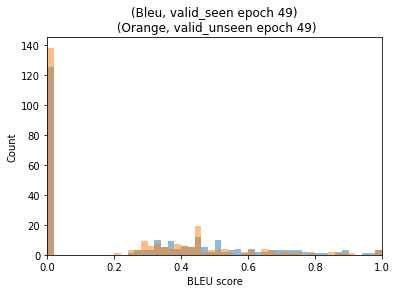

In [13]:
plt.hist(all_valid_seen_bleu_scores, density=False, bins=50, alpha=0.5)
plt.hist(all_valid_unseen_bleu_scores, density=False, bins=50, alpha=0.5)
plt.xlim(0.0, 1.0)
plt.title('(Bleu, valid_seen epoch {})\n (Orange, valid_unseen epoch {})'.format(valid_seen_best_epoch, valid_unseen_best_epoch))
plt.ylabel('Count')
plt.xlabel('BLEU score');

In [17]:
# BEST valid_seen
best_valid_seen_res = examine_sampled_tasks(sampled_task_ids=ranked_valid_seen_ids_best_10, epoch_list=valid_seen_epoch_list, split='valid_seen')

SPLIT: valid_seen



TASK : trial_T20190910_173916_331859_0
ROOT: data/json_feat_2.1.0/pick_cool_then_place_in_recep-Tomato-None-Microwave-13/trial_T20190910_173916_331859
Number of subgoals : 7
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'CoolObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'PickupObject', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhe

In [18]:
# BEST valid_unseen
best_valid_unseen_res = examine_sampled_tasks(sampled_task_ids=ranked_valid_unseen_ids_best_10, epoch_list=valid_unseen_epoch_list, split='valid_unseen')

SPLIT: valid_unseen



TASK : trial_T20190909_123918_983775_0
ROOT: data/json_feat_2.1.0/pick_heat_then_place_in_recep-PotatoSliced-None-Fridge-10/trial_T20190909_123918_983775
Number of subgoals : 13
https://youtu.be/1Ha8RLnfsBg
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'SliceObject', 'GotoLocation', 'PutObject', 'GotoLocation', 'PickupObject', 'GotoLocation', 'HeatObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25

In [19]:
# WORST valid_seen
worst_valid_seen_res = examine_sampled_tasks(sampled_task_ids=ranked_valid_seen_ids_worst_10, epoch_list=valid_seen_epoch_list, split='valid_seen')

SPLIT: valid_seen



TASK : trial_T20190906_181501_970690_0
ROOT: data/json_feat_2.1.0/pick_two_obj_and_place-LettuceSliced-None-Fridge-1/trial_T20190906_181501_970690
Number of subgoals : 17
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'PutObject', 'GotoLocation', 'PickupObject', 'GotoLocation', 'SliceObject', 'CoolObject', 'PutObject', 'GotoLocation', 'PickupObject', 'GotoLocation', 'PutObject', 'PickupObject', 'SliceObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'PickupOb

In [20]:
# WORST valid_unseen
worst_valid_unseen_res = examine_sampled_tasks(sampled_task_ids=ranked_valid_unseen_ids_worst_10, epoch_list=valid_unseen_epoch_list, split='valid_unseen')

SPLIT: valid_unseen



TASK : trial_T20190907_171933_349922_0
ROOT: data/json_feat_2.1.0/pick_heat_then_place_in_recep-Mug-None-CoffeeMachine-10/trial_T20190907_171933_349922
Number of subgoals : 7
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'HeatObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'LookDown_15', 'PickupObject', 'LookUp_15', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'LookUp_15', 'LookUp_15', 'LookUp_15', 'OpenObject', 'PutObject', 'CloseObject', 'ToggleObjectOn', 'ToggleObjectOff', 'Open